In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch #for building model, managing data, training
import torch.nn as nn
import torch.optim as optim
import torchvision    #handles images data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt #for display of images
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Image transformations (grayscale + normalization to [-1, 1])
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize all images to 32x32
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Update this path to your actual folder:
dataset_path = '/content/drive/MyDrive/preprocess_images/'

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

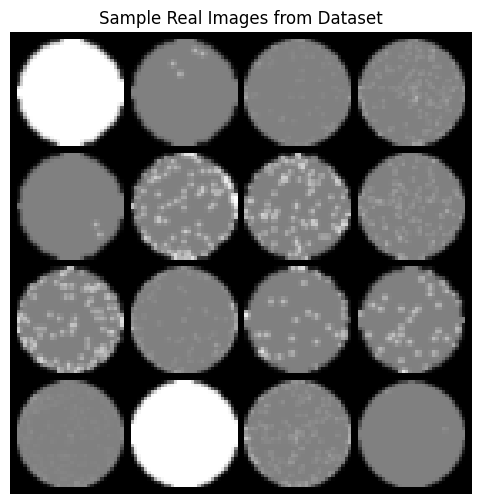

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Get one batch of images
real_batch = next(iter(dataloader))
images, labels = real_batch  # we won't use labels here

# Denormalize the images from [-1, 1] back to [0, 1] for display
images = images * 0.5 + 0.5

# Create a grid of images
grid = torchvision.utils.make_grid(images[:16], nrow=4, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap='gray')
plt.axis('off')
plt.title("Sample Real Images from Dataset")
plt.show()


In [ ]:
latent_dim = 100
lr = 0.0001
beta1 = 0.5
beta2 = 0.999
num_epochs = 200
batch_size = 32

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, 8, 8)),

            nn.Upsample(scale_factor=2),  # 16x16
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Upsample(scale_factor=2),  # 32x32
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


In [ ]:
# Assuming these are already defined
latent_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create generator and move to device
generator = Generator(latent_dim).to(device)

# Create test noise vector with shape [1, latent_dim]
test_noise = torch.randn(1, latent_dim).to(device)

# Generate image
gen_img = generator(test_noise)

# Print output shape
print("Generator output shape:", gen_img.shape)


Generator output shape: torch.Size([1, 1, 32, 32])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.AdaptiveAvgPool2d((1, 1)),  # <--- This ensures consistent output size


            nn.Flatten(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
# Create Discriminator and move to device
discriminator = Discriminator().to(device)

# Create a dummy input image of size [1, 1, 32, 32]
test_image = torch.randn(1, 1, 32, 32).to(device)

# Forward pass
output = discriminator(test_image)

# Print output shape
print("Discriminator output shape:", output.shape)


Discriminator output shape: torch.Size([1, 1])


In [ ]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()  #binary cross entropy real image as 1 and fake image as 0

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))


Epoch [1/200] Batch 1/63 D Loss: 0.6975 G Loss: 0.5936
Epoch [1/200] Batch 2/63 D Loss: 0.6983 G Loss: 0.5941
Epoch [1/200] Batch 3/63 D Loss: 0.6995 G Loss: 0.5890
Epoch [1/200] Batch 4/63 D Loss: 0.7022 G Loss: 0.6055
Epoch [1/200] Batch 5/63 D Loss: 0.7027 G Loss: 0.5998
Epoch [1/200] Batch 6/63 D Loss: 0.6900 G Loss: 0.6101
Epoch [1/200] Batch 7/63 D Loss: 0.7014 G Loss: 0.5998
Epoch [1/200] Batch 8/63 D Loss: 0.7003 G Loss: 0.6110
Epoch [1/200] Batch 9/63 D Loss: 0.6966 G Loss: 0.6083
Epoch [1/200] Batch 10/63 D Loss: 0.6879 G Loss: 0.6072
Epoch [1/200] Batch 11/63 D Loss: 0.7003 G Loss: 0.6113
Epoch [1/200] Batch 12/63 D Loss: 0.6885 G Loss: 0.6178
Epoch [1/200] Batch 13/63 D Loss: 0.6910 G Loss: 0.6180
Epoch [1/200] Batch 14/63 D Loss: 0.6933 G Loss: 0.6163
Epoch [1/200] Batch 15/63 D Loss: 0.6906 G Loss: 0.6135
Epoch [1/200] Batch 16/63 D Loss: 0.6806 G Loss: 0.6225
Epoch [1/200] Batch 17/63 D Loss: 0.6882 G Loss: 0.6236
Epoch [1/200] Batch 18/63 D Loss: 0.6897 G Loss: 0.6124
E

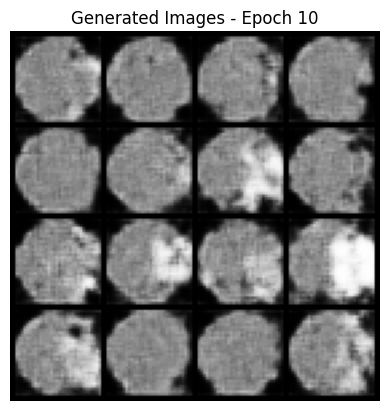

Epoch [11/200] Batch 1/63 D Loss: 0.6364 G Loss: 0.7732
Epoch [11/200] Batch 2/63 D Loss: 0.6648 G Loss: 0.7474
Epoch [11/200] Batch 3/63 D Loss: 0.6178 G Loss: 0.7651
Epoch [11/200] Batch 4/63 D Loss: 0.6344 G Loss: 0.7597
Epoch [11/200] Batch 5/63 D Loss: 0.6429 G Loss: 0.7557
Epoch [11/200] Batch 6/63 D Loss: 0.6295 G Loss: 0.7845
Epoch [11/200] Batch 7/63 D Loss: 0.6594 G Loss: 0.7998
Epoch [11/200] Batch 8/63 D Loss: 0.6291 G Loss: 0.7860
Epoch [11/200] Batch 9/63 D Loss: 0.6167 G Loss: 0.7839
Epoch [11/200] Batch 10/63 D Loss: 0.6463 G Loss: 0.7688
Epoch [11/200] Batch 11/63 D Loss: 0.6226 G Loss: 0.7904
Epoch [11/200] Batch 12/63 D Loss: 0.6344 G Loss: 0.7602
Epoch [11/200] Batch 13/63 D Loss: 0.6383 G Loss: 0.7503
Epoch [11/200] Batch 14/63 D Loss: 0.6312 G Loss: 0.8120
Epoch [11/200] Batch 15/63 D Loss: 0.6379 G Loss: 0.7414
Epoch [11/200] Batch 16/63 D Loss: 0.6281 G Loss: 0.7463
Epoch [11/200] Batch 17/63 D Loss: 0.6093 G Loss: 0.7901
Epoch [11/200] Batch 18/63 D Loss: 0.628

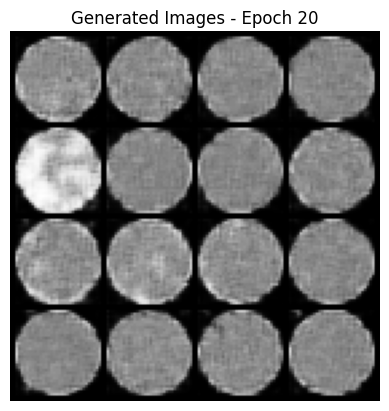

Epoch [21/200] Batch 1/63 D Loss: 0.6971 G Loss: 0.7303
Epoch [21/200] Batch 2/63 D Loss: 0.6820 G Loss: 0.7492
Epoch [21/200] Batch 3/63 D Loss: 0.7155 G Loss: 0.7233
Epoch [21/200] Batch 4/63 D Loss: 0.6885 G Loss: 0.8217
Epoch [21/200] Batch 5/63 D Loss: 0.6647 G Loss: 0.7357
Epoch [21/200] Batch 6/63 D Loss: 0.6717 G Loss: 0.7394
Epoch [21/200] Batch 7/63 D Loss: 0.6801 G Loss: 0.7077
Epoch [21/200] Batch 8/63 D Loss: 0.6643 G Loss: 0.7294
Epoch [21/200] Batch 9/63 D Loss: 0.7185 G Loss: 0.7308
Epoch [21/200] Batch 10/63 D Loss: 0.6987 G Loss: 0.7176
Epoch [21/200] Batch 11/63 D Loss: 0.6423 G Loss: 0.7782
Epoch [21/200] Batch 12/63 D Loss: 0.6669 G Loss: 0.7285
Epoch [21/200] Batch 13/63 D Loss: 0.6908 G Loss: 0.6819
Epoch [21/200] Batch 14/63 D Loss: 0.6800 G Loss: 0.7667
Epoch [21/200] Batch 15/63 D Loss: 0.6602 G Loss: 0.7183
Epoch [21/200] Batch 16/63 D Loss: 0.6836 G Loss: 0.7068
Epoch [21/200] Batch 17/63 D Loss: 0.6703 G Loss: 0.7149
Epoch [21/200] Batch 18/63 D Loss: 0.716

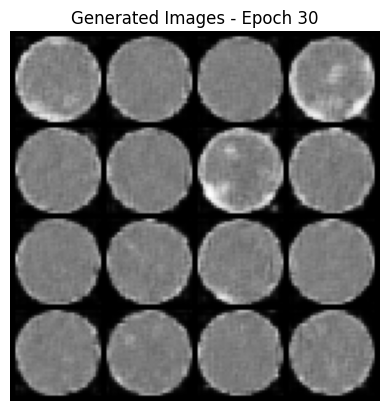

Epoch [31/200] Batch 1/63 D Loss: 0.6864 G Loss: 0.6532
Epoch [31/200] Batch 2/63 D Loss: 0.6978 G Loss: 0.7122
Epoch [31/200] Batch 3/63 D Loss: 0.6903 G Loss: 0.7378
Epoch [31/200] Batch 4/63 D Loss: 0.6958 G Loss: 0.7185
Epoch [31/200] Batch 5/63 D Loss: 0.7004 G Loss: 0.7374
Epoch [31/200] Batch 6/63 D Loss: 0.6689 G Loss: 0.7693
Epoch [31/200] Batch 7/63 D Loss: 0.6905 G Loss: 0.7223
Epoch [31/200] Batch 8/63 D Loss: 0.7116 G Loss: 0.6978
Epoch [31/200] Batch 9/63 D Loss: 0.6718 G Loss: 0.7654
Epoch [31/200] Batch 10/63 D Loss: 0.6720 G Loss: 0.7171
Epoch [31/200] Batch 11/63 D Loss: 0.7106 G Loss: 0.7512
Epoch [31/200] Batch 12/63 D Loss: 0.6832 G Loss: 0.7481
Epoch [31/200] Batch 13/63 D Loss: 0.6965 G Loss: 0.7052
Epoch [31/200] Batch 14/63 D Loss: 0.6737 G Loss: 0.7853
Epoch [31/200] Batch 15/63 D Loss: 0.6878 G Loss: 0.7368
Epoch [31/200] Batch 16/63 D Loss: 0.6569 G Loss: 0.7484
Epoch [31/200] Batch 17/63 D Loss: 0.7062 G Loss: 0.7038
Epoch [31/200] Batch 18/63 D Loss: 0.684

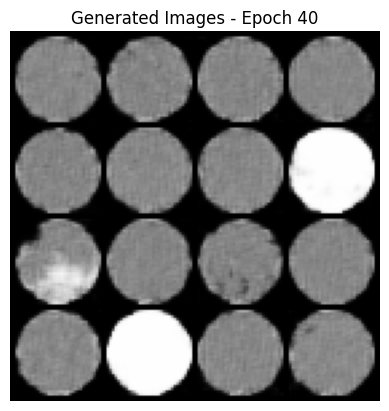

Epoch [41/200] Batch 1/63 D Loss: 0.6535 G Loss: 0.7793
Epoch [41/200] Batch 2/63 D Loss: 0.6712 G Loss: 0.7634
Epoch [41/200] Batch 3/63 D Loss: 0.6677 G Loss: 0.7124
Epoch [41/200] Batch 4/63 D Loss: 0.6802 G Loss: 0.6933
Epoch [41/200] Batch 5/63 D Loss: 0.7148 G Loss: 0.7515
Epoch [41/200] Batch 6/63 D Loss: 0.6717 G Loss: 0.7441
Epoch [41/200] Batch 7/63 D Loss: 0.6351 G Loss: 0.8245
Epoch [41/200] Batch 8/63 D Loss: 0.6831 G Loss: 0.6611
Epoch [41/200] Batch 9/63 D Loss: 0.6655 G Loss: 0.7351
Epoch [41/200] Batch 10/63 D Loss: 0.6578 G Loss: 0.8180
Epoch [41/200] Batch 11/63 D Loss: 0.7267 G Loss: 0.6439
Epoch [41/200] Batch 12/63 D Loss: 0.6946 G Loss: 0.7025
Epoch [41/200] Batch 13/63 D Loss: 0.6585 G Loss: 0.6980
Epoch [41/200] Batch 14/63 D Loss: 0.6543 G Loss: 0.7320
Epoch [41/200] Batch 15/63 D Loss: 0.6507 G Loss: 0.7706
Epoch [41/200] Batch 16/63 D Loss: 0.6702 G Loss: 0.7005
Epoch [41/200] Batch 17/63 D Loss: 0.6657 G Loss: 0.7127
Epoch [41/200] Batch 18/63 D Loss: 0.717

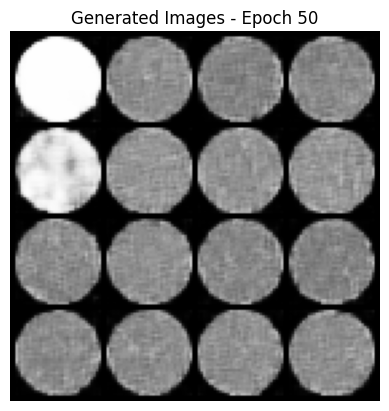

Epoch [51/200] Batch 1/63 D Loss: 0.6728 G Loss: 0.7253
Epoch [51/200] Batch 2/63 D Loss: 0.6471 G Loss: 0.8046
Epoch [51/200] Batch 3/63 D Loss: 0.6888 G Loss: 0.6889
Epoch [51/200] Batch 4/63 D Loss: 0.6386 G Loss: 0.7551
Epoch [51/200] Batch 5/63 D Loss: 0.6749 G Loss: 0.7057
Epoch [51/200] Batch 6/63 D Loss: 0.6752 G Loss: 0.8004
Epoch [51/200] Batch 7/63 D Loss: 0.6627 G Loss: 0.7321
Epoch [51/200] Batch 8/63 D Loss: 0.6466 G Loss: 0.7249
Epoch [51/200] Batch 9/63 D Loss: 0.7025 G Loss: 0.7178
Epoch [51/200] Batch 10/63 D Loss: 0.6644 G Loss: 0.7191
Epoch [51/200] Batch 11/63 D Loss: 0.6557 G Loss: 0.6943
Epoch [51/200] Batch 12/63 D Loss: 0.6949 G Loss: 0.7060
Epoch [51/200] Batch 13/63 D Loss: 0.6581 G Loss: 0.7450
Epoch [51/200] Batch 14/63 D Loss: 0.6922 G Loss: 0.6846
Epoch [51/200] Batch 15/63 D Loss: 0.6622 G Loss: 0.7257
Epoch [51/200] Batch 16/63 D Loss: 0.7049 G Loss: 0.7738
Epoch [51/200] Batch 17/63 D Loss: 0.7171 G Loss: 0.6884
Epoch [51/200] Batch 18/63 D Loss: 0.618

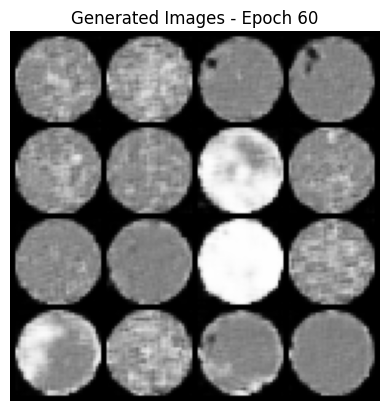

Epoch [61/200] Batch 1/63 D Loss: 0.7161 G Loss: 0.7123
Epoch [61/200] Batch 2/63 D Loss: 0.7078 G Loss: 0.7276
Epoch [61/200] Batch 3/63 D Loss: 0.6913 G Loss: 0.7478
Epoch [61/200] Batch 4/63 D Loss: 0.6849 G Loss: 0.7119
Epoch [61/200] Batch 5/63 D Loss: 0.6524 G Loss: 0.7449
Epoch [61/200] Batch 6/63 D Loss: 0.6789 G Loss: 0.7069
Epoch [61/200] Batch 7/63 D Loss: 0.6659 G Loss: 0.7359
Epoch [61/200] Batch 8/63 D Loss: 0.6692 G Loss: 0.7065
Epoch [61/200] Batch 9/63 D Loss: 0.6479 G Loss: 0.7007
Epoch [61/200] Batch 10/63 D Loss: 0.7078 G Loss: 0.7219
Epoch [61/200] Batch 11/63 D Loss: 0.6471 G Loss: 0.7772
Epoch [61/200] Batch 12/63 D Loss: 0.7038 G Loss: 0.7778
Epoch [61/200] Batch 13/63 D Loss: 0.6673 G Loss: 0.7985
Epoch [61/200] Batch 14/63 D Loss: 0.6468 G Loss: 0.7772
Epoch [61/200] Batch 15/63 D Loss: 0.6546 G Loss: 0.7122
Epoch [61/200] Batch 16/63 D Loss: 0.6389 G Loss: 0.6696
Epoch [61/200] Batch 17/63 D Loss: 0.6805 G Loss: 0.7076
Epoch [61/200] Batch 18/63 D Loss: 0.656

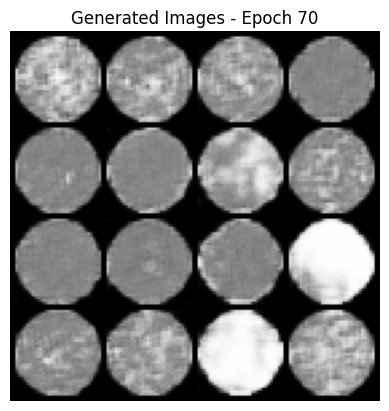

Epoch [71/200] Batch 1/63 D Loss: 0.6934 G Loss: 0.8241
Epoch [71/200] Batch 2/63 D Loss: 0.6938 G Loss: 0.7524
Epoch [71/200] Batch 3/63 D Loss: 0.6569 G Loss: 0.7769
Epoch [71/200] Batch 4/63 D Loss: 0.6672 G Loss: 0.6682
Epoch [71/200] Batch 5/63 D Loss: 0.7122 G Loss: 0.6300
Epoch [71/200] Batch 6/63 D Loss: 0.6748 G Loss: 0.7538
Epoch [71/200] Batch 7/63 D Loss: 0.7041 G Loss: 0.6775
Epoch [71/200] Batch 8/63 D Loss: 0.6432 G Loss: 0.6845
Epoch [71/200] Batch 9/63 D Loss: 0.6660 G Loss: 0.7096
Epoch [71/200] Batch 10/63 D Loss: 0.6478 G Loss: 0.7676
Epoch [71/200] Batch 11/63 D Loss: 0.6549 G Loss: 0.7845
Epoch [71/200] Batch 12/63 D Loss: 0.6602 G Loss: 0.8117
Epoch [71/200] Batch 13/63 D Loss: 0.6682 G Loss: 0.7629
Epoch [71/200] Batch 14/63 D Loss: 0.6474 G Loss: 0.7275
Epoch [71/200] Batch 15/63 D Loss: 0.6643 G Loss: 0.7692
Epoch [71/200] Batch 16/63 D Loss: 0.6604 G Loss: 0.7161
Epoch [71/200] Batch 17/63 D Loss: 0.6945 G Loss: 0.7300
Epoch [71/200] Batch 18/63 D Loss: 0.674

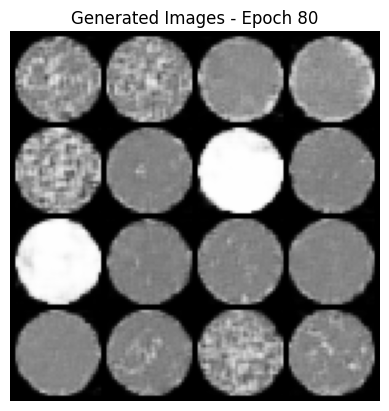

Epoch [81/200] Batch 1/63 D Loss: 0.6663 G Loss: 0.7295
Epoch [81/200] Batch 2/63 D Loss: 0.6588 G Loss: 0.6455
Epoch [81/200] Batch 3/63 D Loss: 0.6944 G Loss: 0.7260
Epoch [81/200] Batch 4/63 D Loss: 0.6294 G Loss: 0.7554
Epoch [81/200] Batch 5/63 D Loss: 0.6426 G Loss: 0.8007
Epoch [81/200] Batch 6/63 D Loss: 0.7352 G Loss: 0.6696
Epoch [81/200] Batch 7/63 D Loss: 0.5650 G Loss: 0.7317
Epoch [81/200] Batch 8/63 D Loss: 0.6698 G Loss: 0.7617
Epoch [81/200] Batch 9/63 D Loss: 0.6839 G Loss: 0.7512
Epoch [81/200] Batch 10/63 D Loss: 0.6814 G Loss: 0.7046
Epoch [81/200] Batch 11/63 D Loss: 0.5990 G Loss: 0.8044
Epoch [81/200] Batch 12/63 D Loss: 0.6836 G Loss: 0.7779
Epoch [81/200] Batch 13/63 D Loss: 0.6773 G Loss: 0.7551
Epoch [81/200] Batch 14/63 D Loss: 0.6856 G Loss: 0.7372
Epoch [81/200] Batch 15/63 D Loss: 0.7147 G Loss: 0.7756
Epoch [81/200] Batch 16/63 D Loss: 0.6258 G Loss: 0.7646
Epoch [81/200] Batch 17/63 D Loss: 0.6751 G Loss: 0.7415
Epoch [81/200] Batch 18/63 D Loss: 0.703

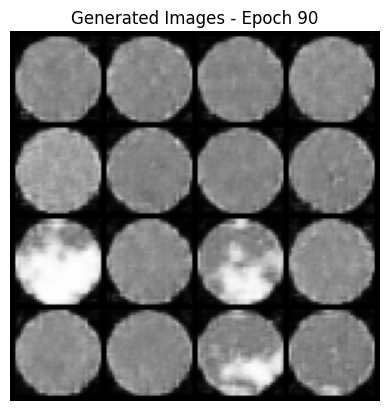

Epoch [91/200] Batch 1/63 D Loss: 0.6498 G Loss: 0.8402
Epoch [91/200] Batch 2/63 D Loss: 0.6068 G Loss: 0.7990
Epoch [91/200] Batch 3/63 D Loss: 0.8708 G Loss: 0.7516
Epoch [91/200] Batch 4/63 D Loss: 0.5985 G Loss: 0.7861
Epoch [91/200] Batch 5/63 D Loss: 0.6354 G Loss: 0.8174
Epoch [91/200] Batch 6/63 D Loss: 0.6594 G Loss: 0.7630
Epoch [91/200] Batch 7/63 D Loss: 0.6072 G Loss: 0.7454
Epoch [91/200] Batch 8/63 D Loss: 0.6412 G Loss: 0.8000
Epoch [91/200] Batch 9/63 D Loss: 0.6602 G Loss: 0.7165
Epoch [91/200] Batch 10/63 D Loss: 0.6639 G Loss: 0.6643
Epoch [91/200] Batch 11/63 D Loss: 0.7098 G Loss: 0.7434
Epoch [91/200] Batch 12/63 D Loss: 0.6221 G Loss: 0.7564
Epoch [91/200] Batch 13/63 D Loss: 0.6508 G Loss: 0.8911
Epoch [91/200] Batch 14/63 D Loss: 0.6428 G Loss: 0.7857
Epoch [91/200] Batch 15/63 D Loss: 0.6636 G Loss: 0.7511
Epoch [91/200] Batch 16/63 D Loss: 0.6934 G Loss: 0.7375
Epoch [91/200] Batch 17/63 D Loss: 0.6460 G Loss: 0.7648
Epoch [91/200] Batch 18/63 D Loss: 0.680

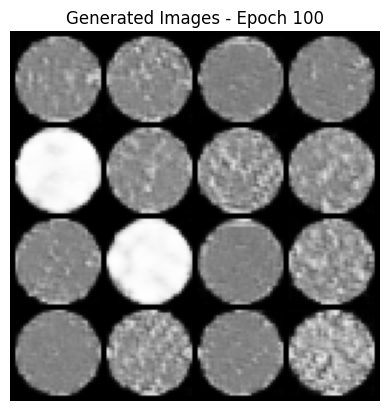

Epoch [101/200] Batch 1/63 D Loss: 0.5779 G Loss: 0.8638
Epoch [101/200] Batch 2/63 D Loss: 0.6536 G Loss: 0.7558
Epoch [101/200] Batch 3/63 D Loss: 0.6846 G Loss: 0.6504
Epoch [101/200] Batch 4/63 D Loss: 0.6356 G Loss: 0.7903
Epoch [101/200] Batch 5/63 D Loss: 0.6986 G Loss: 0.6692
Epoch [101/200] Batch 6/63 D Loss: 0.6249 G Loss: 0.5762
Epoch [101/200] Batch 7/63 D Loss: 0.6532 G Loss: 0.7299
Epoch [101/200] Batch 8/63 D Loss: 0.6917 G Loss: 0.7129
Epoch [101/200] Batch 9/63 D Loss: 0.6384 G Loss: 0.8586
Epoch [101/200] Batch 10/63 D Loss: 0.7214 G Loss: 0.6266
Epoch [101/200] Batch 11/63 D Loss: 0.7253 G Loss: 0.7451
Epoch [101/200] Batch 12/63 D Loss: 0.5737 G Loss: 0.9567
Epoch [101/200] Batch 13/63 D Loss: 0.7295 G Loss: 0.7119
Epoch [101/200] Batch 14/63 D Loss: 0.6395 G Loss: 0.8084
Epoch [101/200] Batch 15/63 D Loss: 0.6645 G Loss: 0.8362
Epoch [101/200] Batch 16/63 D Loss: 0.6044 G Loss: 0.8366
Epoch [101/200] Batch 17/63 D Loss: 0.6120 G Loss: 0.8553
Epoch [101/200] Batch 1

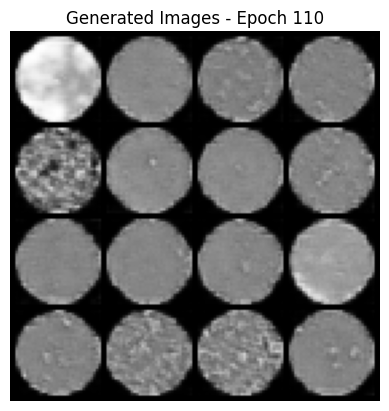

Epoch [111/200] Batch 1/63 D Loss: 0.6186 G Loss: 0.7074
Epoch [111/200] Batch 2/63 D Loss: 0.7053 G Loss: 0.6573
Epoch [111/200] Batch 3/63 D Loss: 0.8912 G Loss: 0.6139
Epoch [111/200] Batch 4/63 D Loss: 0.5270 G Loss: 0.9699
Epoch [111/200] Batch 5/63 D Loss: 0.5798 G Loss: 1.0200
Epoch [111/200] Batch 6/63 D Loss: 0.5273 G Loss: 0.9707
Epoch [111/200] Batch 7/63 D Loss: 0.6012 G Loss: 0.6916
Epoch [111/200] Batch 8/63 D Loss: 0.5553 G Loss: 0.9605
Epoch [111/200] Batch 9/63 D Loss: 0.6107 G Loss: 0.8070
Epoch [111/200] Batch 10/63 D Loss: 0.5891 G Loss: 0.7468
Epoch [111/200] Batch 11/63 D Loss: 0.6974 G Loss: 0.7261
Epoch [111/200] Batch 12/63 D Loss: 0.6661 G Loss: 0.6898
Epoch [111/200] Batch 13/63 D Loss: 0.8397 G Loss: 0.6481
Epoch [111/200] Batch 14/63 D Loss: 0.6531 G Loss: 0.7259
Epoch [111/200] Batch 15/63 D Loss: 0.6951 G Loss: 0.6429
Epoch [111/200] Batch 16/63 D Loss: 0.6807 G Loss: 0.6633
Epoch [111/200] Batch 17/63 D Loss: 0.6234 G Loss: 0.7599
Epoch [111/200] Batch 1

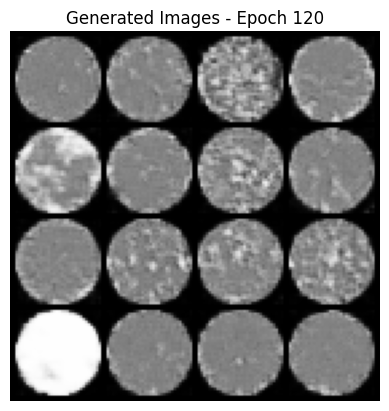

Epoch [121/200] Batch 1/63 D Loss: 0.6644 G Loss: 0.7611
Epoch [121/200] Batch 2/63 D Loss: 0.6508 G Loss: 0.9026
Epoch [121/200] Batch 3/63 D Loss: 0.6266 G Loss: 0.8423
Epoch [121/200] Batch 4/63 D Loss: 0.6349 G Loss: 0.8326
Epoch [121/200] Batch 5/63 D Loss: 0.6652 G Loss: 0.6482
Epoch [121/200] Batch 6/63 D Loss: 0.7995 G Loss: 0.7234
Epoch [121/200] Batch 7/63 D Loss: 0.6186 G Loss: 0.7647
Epoch [121/200] Batch 8/63 D Loss: 0.6654 G Loss: 0.6941
Epoch [121/200] Batch 9/63 D Loss: 0.5993 G Loss: 0.8215
Epoch [121/200] Batch 10/63 D Loss: 0.6767 G Loss: 0.6313
Epoch [121/200] Batch 11/63 D Loss: 0.7378 G Loss: 0.5710
Epoch [121/200] Batch 12/63 D Loss: 0.6794 G Loss: 0.7498
Epoch [121/200] Batch 13/63 D Loss: 0.7039 G Loss: 0.7121
Epoch [121/200] Batch 14/63 D Loss: 0.6717 G Loss: 0.7556
Epoch [121/200] Batch 15/63 D Loss: 0.6087 G Loss: 0.8185
Epoch [121/200] Batch 16/63 D Loss: 0.6197 G Loss: 0.9198
Epoch [121/200] Batch 17/63 D Loss: 0.6632 G Loss: 0.8210
Epoch [121/200] Batch 1

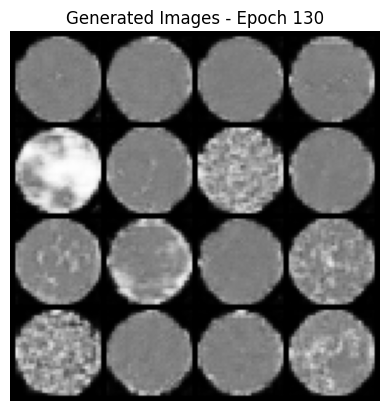

Epoch [131/200] Batch 1/63 D Loss: 0.6976 G Loss: 0.6379
Epoch [131/200] Batch 2/63 D Loss: 0.7005 G Loss: 0.7297
Epoch [131/200] Batch 3/63 D Loss: 0.7909 G Loss: 0.6920
Epoch [131/200] Batch 4/63 D Loss: 0.7050 G Loss: 0.6915
Epoch [131/200] Batch 5/63 D Loss: 0.5582 G Loss: 0.8638
Epoch [131/200] Batch 6/63 D Loss: 0.6136 G Loss: 0.7195
Epoch [131/200] Batch 7/63 D Loss: 0.6330 G Loss: 0.7795
Epoch [131/200] Batch 8/63 D Loss: 0.8519 G Loss: 0.6125
Epoch [131/200] Batch 9/63 D Loss: 0.6292 G Loss: 0.7384
Epoch [131/200] Batch 10/63 D Loss: 0.5982 G Loss: 0.9419
Epoch [131/200] Batch 11/63 D Loss: 0.6872 G Loss: 0.7339
Epoch [131/200] Batch 12/63 D Loss: 0.6477 G Loss: 0.7013
Epoch [131/200] Batch 13/63 D Loss: 0.6152 G Loss: 0.8277
Epoch [131/200] Batch 14/63 D Loss: 0.6954 G Loss: 0.6276
Epoch [131/200] Batch 15/63 D Loss: 0.7105 G Loss: 0.6980
Epoch [131/200] Batch 16/63 D Loss: 0.7671 G Loss: 0.6462
Epoch [131/200] Batch 17/63 D Loss: 0.7244 G Loss: 0.9060
Epoch [131/200] Batch 1

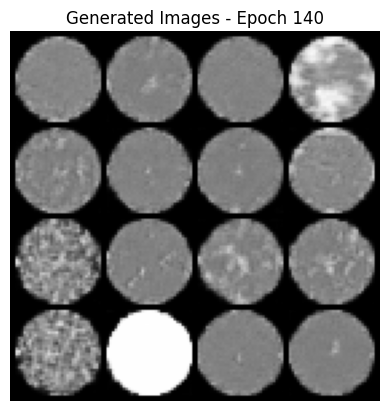

Epoch [141/200] Batch 1/63 D Loss: 0.6594 G Loss: 0.7782
Epoch [141/200] Batch 2/63 D Loss: 0.6933 G Loss: 0.6738
Epoch [141/200] Batch 3/63 D Loss: 0.5479 G Loss: 0.7926
Epoch [141/200] Batch 4/63 D Loss: 0.5622 G Loss: 0.7535
Epoch [141/200] Batch 5/63 D Loss: 0.6379 G Loss: 0.7860
Epoch [141/200] Batch 6/63 D Loss: 0.6891 G Loss: 0.7553
Epoch [141/200] Batch 7/63 D Loss: 0.6859 G Loss: 0.7431
Epoch [141/200] Batch 8/63 D Loss: 0.6529 G Loss: 0.6529
Epoch [141/200] Batch 9/63 D Loss: 0.6238 G Loss: 0.7507
Epoch [141/200] Batch 10/63 D Loss: 0.6916 G Loss: 0.7981
Epoch [141/200] Batch 11/63 D Loss: 0.6309 G Loss: 0.7998
Epoch [141/200] Batch 12/63 D Loss: 0.6907 G Loss: 0.6682
Epoch [141/200] Batch 13/63 D Loss: 0.6984 G Loss: 0.6804
Epoch [141/200] Batch 14/63 D Loss: 0.6912 G Loss: 0.6871
Epoch [141/200] Batch 15/63 D Loss: 0.6163 G Loss: 0.7830
Epoch [141/200] Batch 16/63 D Loss: 0.6915 G Loss: 0.6154
Epoch [141/200] Batch 17/63 D Loss: 0.6305 G Loss: 0.7555
Epoch [141/200] Batch 1

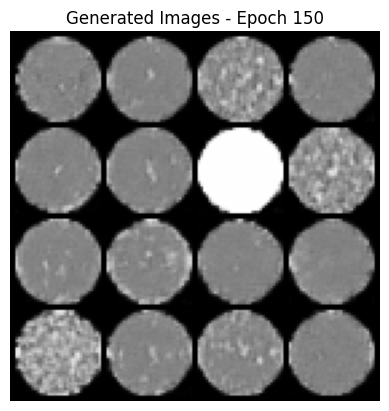

Epoch [151/200] Batch 1/63 D Loss: 0.5978 G Loss: 0.8476
Epoch [151/200] Batch 2/63 D Loss: 0.6589 G Loss: 0.7717
Epoch [151/200] Batch 3/63 D Loss: 0.6494 G Loss: 0.6642
Epoch [151/200] Batch 4/63 D Loss: 0.6583 G Loss: 0.7102
Epoch [151/200] Batch 5/63 D Loss: 0.6686 G Loss: 0.7412
Epoch [151/200] Batch 6/63 D Loss: 0.6531 G Loss: 0.8068
Epoch [151/200] Batch 7/63 D Loss: 0.7076 G Loss: 0.7095
Epoch [151/200] Batch 8/63 D Loss: 0.6254 G Loss: 0.7655
Epoch [151/200] Batch 9/63 D Loss: 0.6315 G Loss: 0.5934
Epoch [151/200] Batch 10/63 D Loss: 0.6556 G Loss: 0.7125
Epoch [151/200] Batch 11/63 D Loss: 0.6936 G Loss: 0.8532
Epoch [151/200] Batch 12/63 D Loss: 0.7851 G Loss: 0.7296
Epoch [151/200] Batch 13/63 D Loss: 0.6074 G Loss: 0.7939
Epoch [151/200] Batch 14/63 D Loss: 0.6077 G Loss: 0.8532
Epoch [151/200] Batch 15/63 D Loss: 0.6257 G Loss: 0.9353
Epoch [151/200] Batch 16/63 D Loss: 0.6409 G Loss: 0.7508
Epoch [151/200] Batch 17/63 D Loss: 0.7367 G Loss: 0.6561
Epoch [151/200] Batch 1

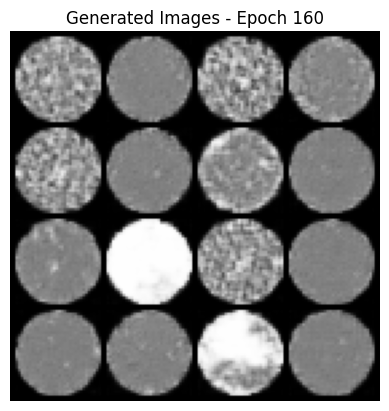

Epoch [161/200] Batch 1/63 D Loss: 0.7106 G Loss: 0.7164
Epoch [161/200] Batch 2/63 D Loss: 0.6717 G Loss: 0.9320
Epoch [161/200] Batch 3/63 D Loss: 0.7813 G Loss: 0.7567
Epoch [161/200] Batch 4/63 D Loss: 0.6709 G Loss: 0.9698
Epoch [161/200] Batch 5/63 D Loss: 0.5744 G Loss: 0.8561
Epoch [161/200] Batch 6/63 D Loss: 0.6940 G Loss: 0.8382
Epoch [161/200] Batch 7/63 D Loss: 0.6593 G Loss: 0.7612
Epoch [161/200] Batch 8/63 D Loss: 0.6259 G Loss: 0.7661
Epoch [161/200] Batch 9/63 D Loss: 0.6960 G Loss: 0.7144
Epoch [161/200] Batch 10/63 D Loss: 0.6878 G Loss: 0.7181
Epoch [161/200] Batch 11/63 D Loss: 0.6483 G Loss: 0.6929
Epoch [161/200] Batch 12/63 D Loss: 0.6203 G Loss: 0.6517
Epoch [161/200] Batch 13/63 D Loss: 0.6787 G Loss: 0.7559
Epoch [161/200] Batch 14/63 D Loss: 0.6624 G Loss: 0.7427
Epoch [161/200] Batch 15/63 D Loss: 0.6434 G Loss: 0.7470
Epoch [161/200] Batch 16/63 D Loss: 0.7032 G Loss: 0.8006
Epoch [161/200] Batch 17/63 D Loss: 0.5820 G Loss: 0.9253
Epoch [161/200] Batch 1

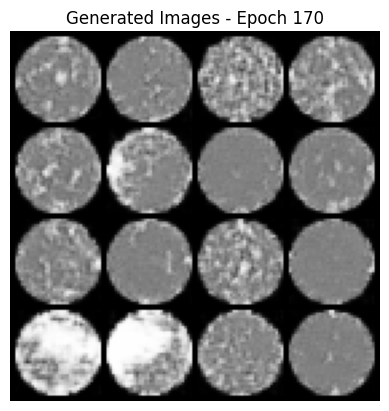

Epoch [171/200] Batch 1/63 D Loss: 0.6460 G Loss: 0.7041
Epoch [171/200] Batch 2/63 D Loss: 0.6375 G Loss: 0.7461
Epoch [171/200] Batch 3/63 D Loss: 0.6767 G Loss: 0.8043
Epoch [171/200] Batch 4/63 D Loss: 0.6357 G Loss: 0.8328
Epoch [171/200] Batch 5/63 D Loss: 0.5743 G Loss: 0.9172
Epoch [171/200] Batch 6/63 D Loss: 0.6091 G Loss: 0.9373
Epoch [171/200] Batch 7/63 D Loss: 0.5742 G Loss: 0.9693
Epoch [171/200] Batch 8/63 D Loss: 0.6712 G Loss: 0.9299
Epoch [171/200] Batch 9/63 D Loss: 0.6964 G Loss: 1.0431
Epoch [171/200] Batch 10/63 D Loss: 0.7000 G Loss: 0.8901
Epoch [171/200] Batch 11/63 D Loss: 0.6380 G Loss: 0.8321
Epoch [171/200] Batch 12/63 D Loss: 0.6297 G Loss: 0.7078
Epoch [171/200] Batch 13/63 D Loss: 0.6022 G Loss: 0.8058
Epoch [171/200] Batch 14/63 D Loss: 0.5874 G Loss: 0.7065
Epoch [171/200] Batch 15/63 D Loss: 0.6680 G Loss: 0.6835
Epoch [171/200] Batch 16/63 D Loss: 0.6894 G Loss: 0.6065
Epoch [171/200] Batch 17/63 D Loss: 0.6198 G Loss: 0.6588
Epoch [171/200] Batch 1

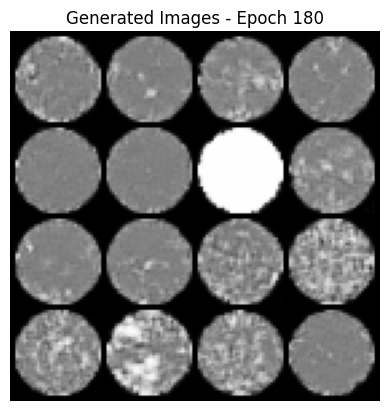

Epoch [181/200] Batch 1/63 D Loss: 0.6867 G Loss: 0.6378
Epoch [181/200] Batch 2/63 D Loss: 0.5702 G Loss: 0.8529
Epoch [181/200] Batch 3/63 D Loss: 0.6687 G Loss: 0.7247
Epoch [181/200] Batch 4/63 D Loss: 0.5749 G Loss: 0.6649
Epoch [181/200] Batch 5/63 D Loss: 0.7783 G Loss: 0.7305
Epoch [181/200] Batch 6/63 D Loss: 0.6308 G Loss: 0.7200
Epoch [181/200] Batch 7/63 D Loss: 0.6970 G Loss: 0.6757
Epoch [181/200] Batch 8/63 D Loss: 0.6672 G Loss: 0.7365
Epoch [181/200] Batch 9/63 D Loss: 0.6428 G Loss: 0.7523
Epoch [181/200] Batch 10/63 D Loss: 0.6837 G Loss: 0.7105
Epoch [181/200] Batch 11/63 D Loss: 0.6293 G Loss: 0.7485
Epoch [181/200] Batch 12/63 D Loss: 0.6073 G Loss: 0.8258
Epoch [181/200] Batch 13/63 D Loss: 0.5350 G Loss: 0.9464
Epoch [181/200] Batch 14/63 D Loss: 0.6905 G Loss: 0.7008
Epoch [181/200] Batch 15/63 D Loss: 0.5973 G Loss: 0.8494
Epoch [181/200] Batch 16/63 D Loss: 0.6631 G Loss: 0.9202
Epoch [181/200] Batch 17/63 D Loss: 0.6565 G Loss: 0.7923
Epoch [181/200] Batch 1

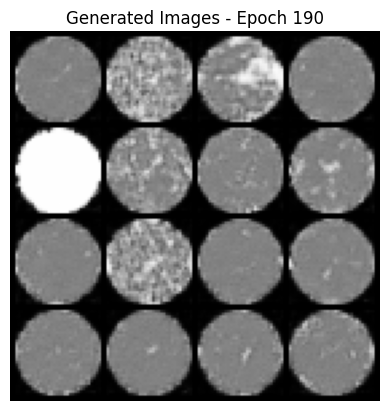

Epoch [191/200] Batch 1/63 D Loss: 0.5873 G Loss: 0.8319
Epoch [191/200] Batch 2/63 D Loss: 0.6908 G Loss: 0.8431
Epoch [191/200] Batch 3/63 D Loss: 0.6468 G Loss: 0.9699
Epoch [191/200] Batch 4/63 D Loss: 0.6985 G Loss: 0.9367
Epoch [191/200] Batch 5/63 D Loss: 0.6457 G Loss: 0.8827
Epoch [191/200] Batch 6/63 D Loss: 0.6180 G Loss: 0.9234
Epoch [191/200] Batch 7/63 D Loss: 0.6524 G Loss: 0.6912
Epoch [191/200] Batch 8/63 D Loss: 0.6234 G Loss: 0.7453
Epoch [191/200] Batch 9/63 D Loss: 0.7079 G Loss: 0.6874
Epoch [191/200] Batch 10/63 D Loss: 0.6874 G Loss: 0.8629
Epoch [191/200] Batch 11/63 D Loss: 0.7125 G Loss: 0.7584
Epoch [191/200] Batch 12/63 D Loss: 0.6605 G Loss: 0.7605
Epoch [191/200] Batch 13/63 D Loss: 0.6206 G Loss: 0.9944
Epoch [191/200] Batch 14/63 D Loss: 0.5458 G Loss: 0.9791
Epoch [191/200] Batch 15/63 D Loss: 0.6538 G Loss: 1.0608
Epoch [191/200] Batch 16/63 D Loss: 0.6922 G Loss: 0.8612
Epoch [191/200] Batch 17/63 D Loss: 0.5318 G Loss: 0.9838
Epoch [191/200] Batch 1

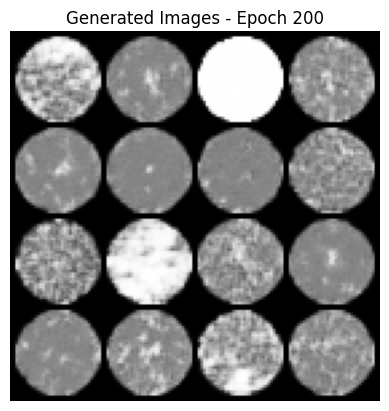

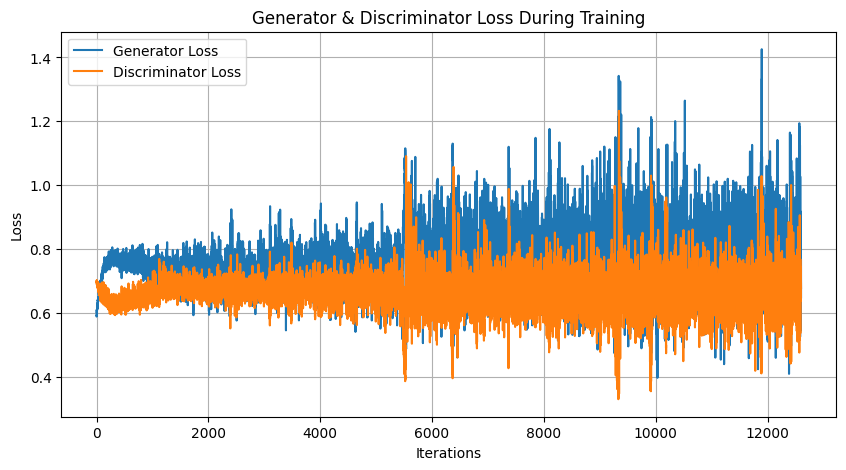

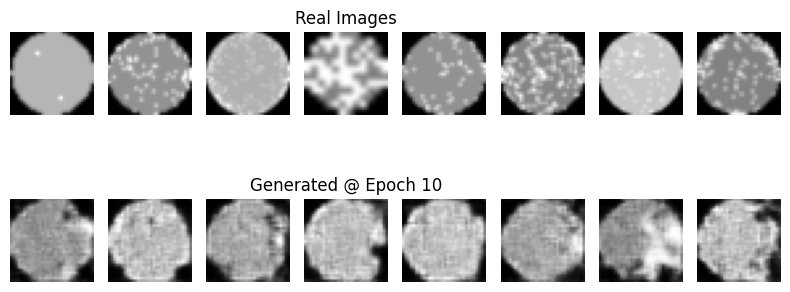

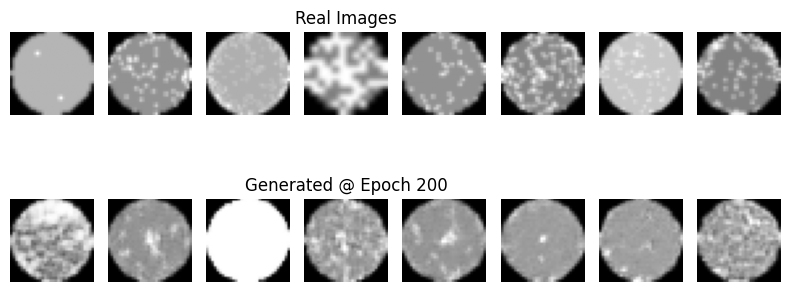

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Track losses
g_losses = []
d_losses = []
gen_images_at_10 = None
gen_images_at_200 = None
real_images_sample = None  # For comparison

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # === Train Discriminator ===
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)  # noise
        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # === Train Generator ===
        optimizer_G.zero_grad()
        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        # Save losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i+1}/{len(dataloader)} D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

        # Save real images sample once
        if real_images_sample is None:
            real_images_sample = real_images[:16].cpu()

    # === Visual Checkpoint (every 10 epochs) ===
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            gen_images = generator(z).cpu()

            # Save for comparison at specific epochs
            if epoch + 1 == 10:
                gen_images_at_10 = gen_images
            elif epoch + 1 == 200:
                gen_images_at_200 = gen_images

            # Display generated image grid
            grid = torchvision.utils.make_grid(gen_images, nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)), cmap='gray')
            plt.axis("off")
            plt.title(f"Generated Images - Epoch {epoch+1}")
            plt.show()

# === Plot Loss Curves (only at the end) ===
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Generator & Discriminator Loss During Training")
plt.legend()
plt.grid(True)
plt.show()

# === Compare Real vs Generated Images ===
def show_comparison(real_imgs, gen_imgs, title):
    plt.figure(figsize=(8, 4))
    for i in range(8):
        # Real
        plt.subplot(2, 8, i + 1)
        plt.imshow(real_imgs[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 3:
            plt.title("Real Images")

        # Generated
        plt.subplot(2, 8, i + 9)
        plt.imshow(gen_imgs[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 3:
            plt.title(title)

    plt.tight_layout()
    plt.show()

# Unnormalize real images for display
real_images_sample = real_images_sample * 0.5 + 0.5

if gen_images_at_10 is not None:
    gen_images_at_10 = gen_images_at_10 * 0.5 + 0.5
    show_comparison(real_images_sample, gen_images_at_10, "Generated @ Epoch 10")

if gen_images_at_200 is not None:
    gen_images_at_200 = gen_images_at_200 * 0.5 + 0.5
    show_comparison(real_images_sample, gen_images_at_200, "Generated @ Epoch 200")


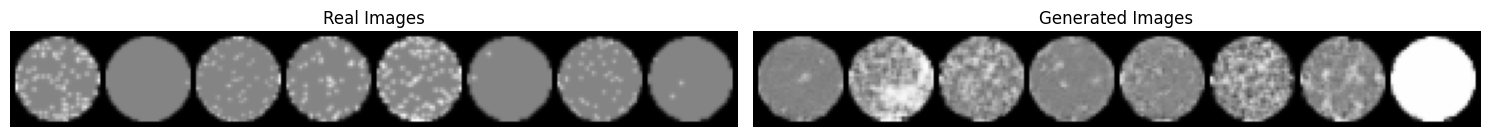

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_real_vs_fake(generator, dataloader, device, latent_dim, n=8):
    # Get a batch of real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:n].to(device)

    # Generate fake images
    z = torch.randn(n, latent_dim, device=device)
    fake_images = generator(z)

    # Move both to CPU for visualization
    real_images = real_images.cpu()
    fake_images = fake_images.cpu()

    # Create a grid of real and fake images
    real_grid = vutils.make_grid(real_images, nrow=n, normalize=True)
    fake_grid = vutils.make_grid(fake_images, nrow=n, normalize=True)

    # Plot side by side
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(real_grid, (1, 2, 0)), cmap='gray')
    plt.title("Real Images")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(fake_grid, (1, 2, 0)), cmap='gray')
    plt.title("Generated Images")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
show_real_vs_fake(generator, dataloader, device, latent_dim)


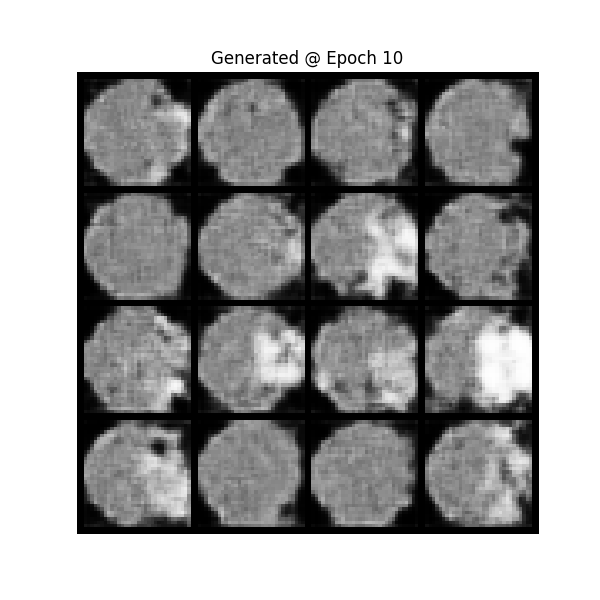

In [21]:
import matplotlib.animation as animation
from IPython.display import Image, display

def animate_generated_images(imgs_list, titles_list):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.axis('off')

    def update(frame):
        ax.clear()
        ax.axis('off')
        img = torchvision.utils.make_grid(imgs_list[frame], nrow=4, normalize=True)
        ax.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')
        ax.set_title(titles_list[frame])

    ani = animation.FuncAnimation(fig, update, frames=len(imgs_list), interval=1500, repeat=True)

    # Save as gif
    gif_path = "/content/gan_progress.gif"
    ani.save(gif_path, writer='imagemagick')
    plt.close(fig)

    display(Image(filename=gif_path))

# Run animation in Colab
if gen_images_at_10 is not None and gen_images_at_200 is not None:
    animate_generated_images([gen_images_at_10, gen_images_at_200], ["Generated @ Epoch 10", "Generated @ Epoch 200"])
else:
    print("No generated images saved at epoch 10 or 200.")


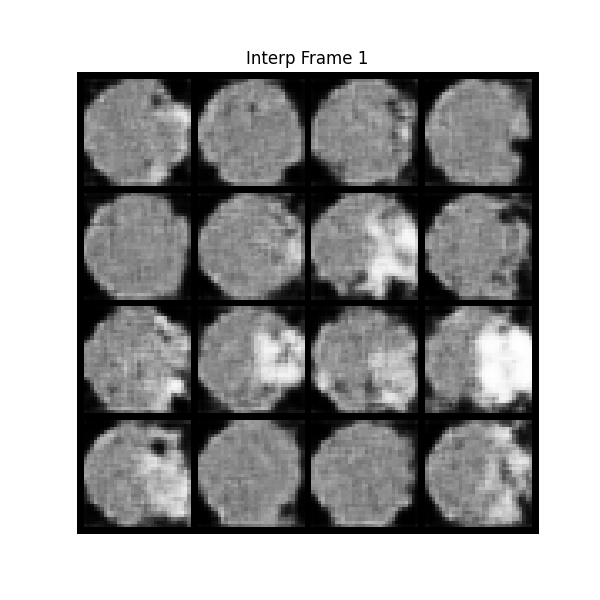

In [27]:
import torch

def interpolate_images(img1, img2, steps=5):
    """
    Linearly interpolate between two batches of images.
    img1, img2: tensors of shape (N, C, H, W)
    steps: number of interpolation frames between img1 and img2
    Returns: list of tensors including start, intermediates, and end
    """
    imgs = []
    for alpha in torch.linspace(0, 1, steps):
        interp_img = (1 - alpha) * img1 + alpha * img2
        imgs.append(interp_img)
    return imgs

# Interpolate with 8 frames between epoch 10 and 200 images (total 9 frames)
if gen_images_at_10 is not None and gen_images_at_200 is not None:
    interpolated_imgs = interpolate_images(gen_images_at_10, gen_images_at_200, steps=9)
    titles = [f"Interp Frame {i+1}" for i in range(len(interpolated_imgs))]

    # Now animate
    animate_generated_images(interpolated_imgs, titles)
else:
    print("Missing generated images at epoch 10 or 200 for interpolation.")


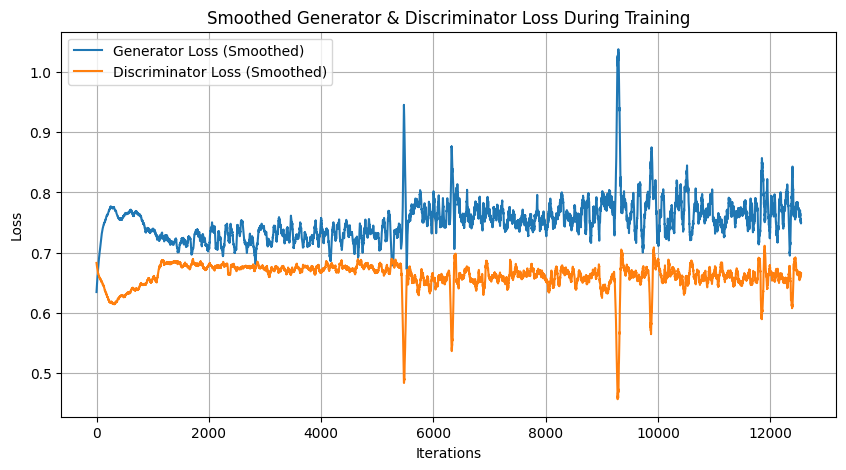

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_curve(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(smooth_curve(g_losses), label='Generator Loss (Smoothed)')
plt.plot(smooth_curve(d_losses), label='Discriminator Loss (Smoothed)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Smoothed Generator & Discriminator Loss During Training')
plt.legend()
plt.grid(True)
plt.show()


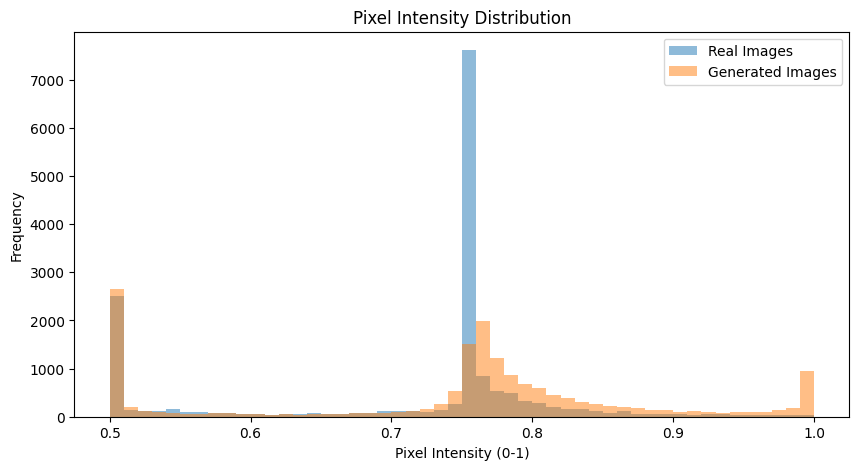

In [19]:
def plot_pixel_histograms(real_imgs, gen_imgs, bins=50):
    real_pixels = real_imgs.flatten().cpu().numpy()
    gen_pixels = gen_imgs.flatten().cpu().numpy()

    plt.figure(figsize=(10,5))
    plt.hist(real_pixels, bins=bins, alpha=0.5, label='Real Images')
    plt.hist(gen_pixels, bins=bins, alpha=0.5, label='Generated Images')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity (0-1)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

if gen_images_at_200 is not None:
    # Unnormalize images first
    real = real_images_sample * 0.5 + 0.5
    gen = gen_images_at_200 * 0.5 + 0.5
    plot_pixel_histograms(real, gen)
else:
    print("No generated images saved at epoch 200.")



✅ Training Complete!
Here is a summary of the GAN training results:



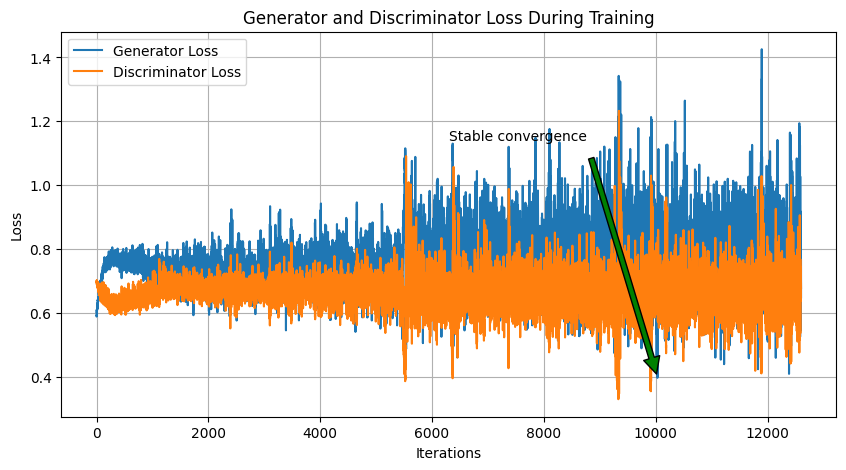

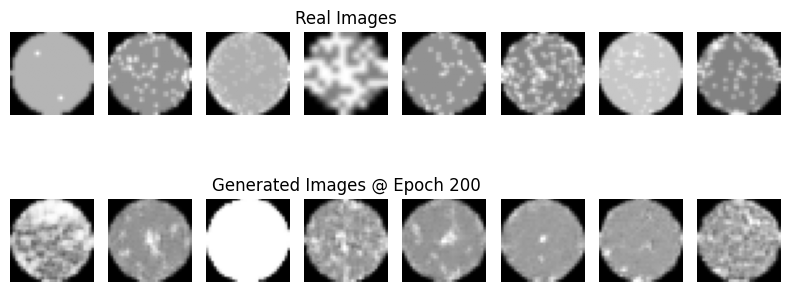

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have g_losses, d_losses, real_images_sample, gen_images_at_200

def final_conclusion(g_losses, d_losses, real_images, gen_images):
    print("\n" + "="*60)
    print("✅ Training Complete!")
    print("Here is a summary of the GAN training results:\n")

    # Plot loss curves with annotations
    plt.figure(figsize=(10,5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Loss During Training')
    plt.legend()
    plt.grid(True)
    plt.annotate('Stable convergence', xy=(len(g_losses)*0.8, min(g_losses)*1.1),
                 xytext=(len(g_losses)*0.5, max(g_losses)*0.8),
                 arrowprops=dict(facecolor='green', shrink=0.05))
    plt.show()

    # Show final real vs generated images side-by-side
    def show_comparison(real_imgs, gen_imgs, title):
        plt.figure(figsize=(8,4))
        for i in range(8):
            plt.subplot(2, 8, i+1)
            plt.imshow(real_imgs[i].squeeze(), cmap='gray')
            plt.axis('off')
            if i == 3:
                plt.title('Real Images')

            plt.subplot(2, 8, i+9)
            plt.imshow(gen_imgs[i].squeeze(), cmap='gray')
            plt.axis('off')
            if i == 3:
                plt.title(title)
        plt.tight_layout()
        plt.show()

    show_comparison(real_images, gen_images, "Generated Images @ Epoch 200")


    print("="*60 + "\n")

# Call it in your notebook after training/visualization:
final_conclusion(g_losses, d_losses, real_images_sample, gen_images_at_200)
